In [1]:
import pandas as pd
import datetime
import sys
sys.path.append('./utils')
from utils import *
from process import * 
from add_list_master import *
import japanize_matplotlib

In [2]:
# データ保存先
data_folda = '../data/'

target_column="target3"
make_genre_list=True

In [4]:
# 説明変数のリスト
explain_columns=add_list_master+add_list_hitosara+add_list_retty+add_list_tripadvisor+add_list_google+add_list_hotpepper
# 重複を削除
explain_columns=list(set(explain_columns))

pseudo_time_series_with = extract_features(data_folda,"train_with_master_structured_main_medias.pkl",explain_columns, target_column)
#non bias dataも読み込む
pseudo_time_series_with_non_bias = extract_features(data_folda,"test3_with_master_structured_main_medias.pkl",explain_columns, target_column)




In [ ]:
pseudo_time_series_with.info()

array(['restaurant_id', 'original_id', 'closed_date', 'base_date',
       'target3', 'target6', 'eval_period', 'id', 'name',
       'prefecture_name', 'head_branch', 'opened_on', 'created_at',
       'genre_first_name', 'genre_second_name', 'genre_third_name',
       'northlatitude', 'eastlongitude', 'net_reservation_flg',
       'price_range_lunch_owner', 'price_range_dinner_owner',
       'price_range_lunch_user', 'price_range_dinner_user',
       'coupons_count', 'review_count', 'hozon_count', 'all_photo_count',
       'photo_food_count', 'photo_drink_count', 'photo_interior_count',
       'photo_exterior_count', 'real_opened_date', 'openning_days',
       'overview.aggregateRating', 'overview.reviewCount',
       'general_rank_GOOGLE', 'infos.isOfficial',
       'infos.familiar.users.genge', 'infos.familiar.users.count',
       'infos.familiar.stars', 'general_rank_RETTY',
       'infos.reserveEntireStore', 'infos.onlineReservation_x',
       'infos.access.transferTime1', 'infos.ac

In [ ]:
if(make_genre_list==True):
    # genreのリストを作成
    genre0=pseudo_time_series_with["genre_first_name"].unique()
    genre1=pseudo_time_series_with["genre_second_name"].unique()
    genre2=pseudo_time_series_with["genre_third_name"].unique()
    
    genre_list = list(set(list(genre0)+list(genre1)+list(genre2)))
    #毎回読み込むのは時間がかかるので、一度読み込んだらpickleで保存しておく
    genre_list = pd.Series(genre_list)
    genre_list.dropna().to_pickle(data_folda+'genre_list.pkl')
    genre_list = pd.read_pickle(data_folda+'genre_list.pkl').dropna().to_list()
else:
    # 保存しておいたgenre_listを、listとして読み込む
    genre_list = pd.read_pickle(data_folda+'genre_list.pkl').dropna().to_list()

In [ ]:
"""
pref_count=pd.DataFrame()
# prefecture 毎の月の店舗数の変化率をカウント

for p in augumented_data["prefecture_name"].unique():
    pnum=augumented_data_train[augumented_data_train["prefecture_name_{}".format(p)]==1].groupby("base_date")["restaurant_id"].count().reset_index()
    pnum["prefecture_name"]=p
    pref_count=pd.concat([pref_count,pnum],axis=0)

# augumented_data_trainにpref_countを結合
for 
                                  
#営業日は日数->整数に変換
augumented_data_train["openning_days"]=augumented_data_train["openning_days"].dt.days.astype(int)

# longitude,latitudeはfloatに変換
augumented_data_train[['northlatitude', 'eastlongitude']]=augumented_data_train[['northlatitude', 'eastlongitude']].astype(float)

augumented_data_train.to_pickle(data_folda+'train'+str(base_month)+".pkl")
"""

'\npref_count=pd.DataFrame()\n# prefecture 毎の月の店舗数の変化率をカウント\n\nfor p in augumented_data["prefecture_name"].unique():\n    pnum=augumented_data_train[augumented_data_train["prefecture_name_{}".format(p)]==1].groupby("base_date")["restaurant_id"].count().reset_index()\n    pnum["prefecture_name"]=p\n    pref_count=pd.concat([pref_count,pnum],axis=0)\n\n# augumented_data_trainにpref_countを結合\nfor \n                                  \n#営業日は日数->整数に変換\naugumented_data_train["openning_days"]=augumented_data_train["openning_days"].dt.days.astype(int)\n\n# longitude,latitudeはfloatに変換\naugumented_data_train[[\'northlatitude\', \'eastlongitude\']]=augumented_data_train[[\'northlatitude\', \'eastlongitude\']].astype(float)\n\naugumented_data_train.to_pickle(data_folda+\'train\'+str(base_month)+".pkl")\n'

In [ ]:
"""
base_month="202311"
augumented_data=pseudo_time_series_with_non_bias

augumented_data_train=augumented_data[(augumented_data['base_date'].dt.strftime('%Y%m')==base_month)
                                    &(augumented_data["eval_period"]==True)]

# 目的変数はclosed_flg_lag3
augumented_data_train=augumented_data_train[explain_columns+[target_column]]

#genre_listでgenre_first_nameをダミー変数化。
#genre_first_nameのみ、genre_second_name,genre_third_name はどうするか。

glist = [pd.DataFrame() for i in range(len(genre_list))]       
# 進行状況を表示
for i in tqdm(range(len(genre_list))):
    glist[i]=augumented_data_train["genre_first_name"].str.contains(genre_list[i]).astype(int)

augumented_data_train=pd.concat([augumented_data_train]+glist,axis=1)

augumented_data_train.columns=explain_columns+[target_column]+["genre_"+g for g in genre_list]

# prefecture をダミー変数化
augumented_data_train=pd.get_dummies(augumented_data_train,columns=["prefecture_name"])

# 各月の店舗数をカウント
name_size=augumented_data_train[["name","base_date"]].value_counts().reset_index()
name_size.rename(columns={0:"name_size"},inplace=True)
augumented_data_train = pd.merge(augumented_data_train,name_size, on=["name","base_date"],how="left")
        
#半径1km以内の店舗数をカウント
#augumented_data_train["name_size_1km"]=augumented_data_train["northlatitude"].apply(lambda x:augumented_data_train[(augumented_data_train["northlatitude"]-x)**2+(augumented_data_train["eastlongitude"]-augumented_data_train["eastlongitude"])**2<0.00001].shape[0])


# 前月/前々月からの店舗数の変化率をカウント
#augumented_data_train["name_size_lag1_ratio"]=augumented_data_train.groupby("restaurant_id")["name_size"].shift(1).bfill()/augumented_data_train["name_size"]
#augumented_data_train["name_size_lag2_ratio"]=augumented_data_train.groupby("restaurant_id")["name_size"].shift(2).bfill()/augumented_data_train["name_size"]


pref_count=pd.DataFrame()
# prefecture 毎の月の店舗数の変化率をカウント
for p in augumented_data_train["prefecture_name"].unique():
    pnum=augumented_data_train[augumented_data_train["prefecture_name"]==p].groupby("base_date")["name"].count()
    pref_count=pd.concat([pref_count,pnum.reset_index],axis=1)


# augumented_data_trainにpref_countを結合
augumented_data_train=pd.merge(augumented_data_train,pref_count,on=["base_date","pre"],how="left")
"""

"""                                  
#営業日は日数->整数に変換
augumented_data_train["openning_days"]=augumented_data_train["openning_days"].dt.days.astype(int)

# longitude,latitudeはfloatに変換
augumented_data_train[['northlatitude', 'eastlongitude']]=augumented_data_train[['northlatitude', 'eastlongitude']].astype(float)

augumented_data_train.to_pickle(data_folda+'train'+str(base_month)+".pkl")
"""

'                                  \n#営業日は日数->整数に変換\naugumented_data_train["openning_days"]=augumented_data_train["openning_days"].dt.days.astype(int)\n\n# longitude,latitudeはfloatに変換\naugumented_data_train[[\'northlatitude\', \'eastlongitude\']]=augumented_data_train[[\'northlatitude\', \'eastlongitude\']].astype(float)\n\naugumented_data_train.to_pickle(data_folda+\'train\'+str(base_month)+".pkl")\n'

In [ ]:
len(explain_columns+[target_column]+["genre_"+g for g in genre_list])

300

In [ ]:
base_month_1="202301"
pseudo_time_series_with_1 = make_train_data(pseudo_time_series_with, base_month_1, explain_columns, target_column,  data_folda, genre_list, read_from_pickle=False)

KeyError: "['infos.onlineReservation', 'infos.premium'] not in index"

In [ ]:
base_month_4="202304"
pseudo_time_series_with_4 = make_train_data(pseudo_time_series_with, base_month_4, explain_columns, target_column,  data_folda, genre_list, read_from_pickle=False)

In [ ]:
base_month_7="202307"
pseudo_time_series_with_7 = make_train_data(pseudo_time_series_with, base_month_7, explain_columns, target_column,  data_folda, genre_list, read_from_pickle=False)

  0%|          | 0/219 [00:00<?, ?it/s]

In [ ]:
# augumented_data_train_1とaugumented_data_train_2を結合
pseudo_time_series_train=pd.concat([pseudo_time_series_with_1
                                    ,pseudo_time_series_with_4
                                    ,pseudo_time_series_with_7])
#del pseudo_time_series_with_0, pseudo_time_series_with_4


In [ ]:
base_month_test="202311"
pseudo_time_series_with_test = make_train_data(pseudo_time_series_with_non_bias, base_month_test, explain_columns, target_column,  data_folda, genre_list, read_from_pickle=False)

  0%|          | 0/219 [00:00<?, ?it/s]

In [ ]:
pseudo_time_series_train=fix_structured_data(pseudo_time_series_train)
pseudo_time_series_with_test=fix_structured_data(pseudo_time_series_with_test)

In [ ]:
test_train_dist=compare_test_train_dist(data_folda,train=pseudo_time_series_train,test=pseudo_time_series_with_test)

/home/ec2-user/dglab-ai-scoring_insitestream/pg/./utils/process.py:261: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_20231130_groupby_mean=pseudo_time_series_with.groupby("target3").mean().T.rename(columns={0:"target0_train_mean",1:"target1_train_mean"})
/home/ec2-user/dglab-ai-scoring_insitestream/pg/./utils/process.py:262: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_20231130_test_groupby_mean=pseudo_time_series_with_test.groupby("target3").mean().T.rename(columns={0:"target0_test_mean",1:"target1_test_mean"})


In [ ]:
test_train_dist.index.values

array(['restaurant_id', 'base_date', 'eval_period', 'name',
       'genre_first_name', 'genre_second_name', 'genre_third_name',
       'northlatitude', 'eastlongitude', 'net_reservation_flg',
       'coupons_count', 'review_count', 'hozon_count', 'all_photo_count',
       'openning_days', 'overview.aggregateRating',
       'overview.reviewCount', 'infos.isOfficial',
       'infos.familiar.users.count', 'infos.onlineReservation',
       'infos.access.transferTime1', 'infos.access.transferTime2',
       'infos.access.transferTime3', 'infos.wantToGo', 'infos.went',
       'infos.rateByWent', 'infos.excellent', 'infos.coupon',
       'infos.photoCount.Photograph', 'infos.photoCount.Cooking',
       'infos.photoCount.Interior', 'infos.photoCount.Exterior',
       'infos.photoCount.Menu', 'infos.reviewCount.Review',
       'infos.reviewCount.Lunch', 'infos.reviewCount.Dinner',
       'menus.course_list_count', 'menus.dishes_list_count',
       'menus.lunch_list_count', 'menus.drink_list_coun

In [ ]:
"""
pref_count=pd.DataFrame()
# prefecture 毎の月の店舗数の変化率をカウント
for p in pseudo_time_series_train["prefecture_name"].unique():
    pnum=pseudo_time_series_train[pseudo_time_series_train["prefecture_name"]==p].groupby("base_date")["name"].count()
    pref_count=pd.concat([pseudo_time_series_train,pnum.reset_index],axis=1)
"""

'\npref_count=pd.DataFrame()\n# prefecture 毎の月の店舗数の変化率をカウント\nfor p in pseudo_time_series_train["prefecture_name"].unique():\n    pnum=pseudo_time_series_train[pseudo_time_series_train["prefecture_name"]==p].groupby("base_date")["name"].count()\n    pref_count=pd.concat([pseudo_time_series_train,pnum.reset_index],axis=1)\n'

In [ ]:
test_train_dist_filter=test_train_dist[test_train_dist["target1_test_count"]>0].dropna()
test_train_dist_filter=test_train_dist_filter[(test_train_dist_filter["test_ratio_over_train_ratio"]>0.0)
                       &(test_train_dist_filter["test_ratio_over_train_ratio"]<10)]

# 1-test_ratio と 1-train_ratio の掛け算が正のものを抽出
test_train_dist_filter=test_train_dist_filter[(1-test_train_dist_filter["test_ratio"]) * (1-test_train_dist_filter["train_ratio"])>0]


ex=test_train_dist_filter.index
ex.values


array(['northlatitude', 'eastlongitude', 'net_reservation_flg',
       'review_count', 'hozon_count', 'all_photo_count', 'openning_days',
       'overview.aggregateRating', 'infos.familiar.users.count',
       'infos.access.transferTime1', 'infos.wantToGo', 'infos.rateByWent',
       'infos.excellent', 'infos.photoCount.Photograph',
       'infos.photoCount.Cooking', 'infos.photoCount.Exterior',
       'infos.reviewCount.Dinner', 'menus.dishes_list_count',
       'menus.lunch_list_count', 'infos.aggregateRating',
       'infos.fanCount', 'infos.reviewTags.count1',
       'infos.reviewTags.count2', 'infos.reviewTags.count3',
       'infos.reviewTags.count4', 'infos.reviewTags.count5',
       'infos.reviewTags.count6', 'infos.reviewTags.count8',
       'infos.reviewTags.count9', 'aggregateRating.ratingCount',
       'infos.aggregateRating_TRIPADVISOR', 'infos.ratingDetails.Meal',
       'infos.ratingDetails.Service', 'infos.ratingDetails.Price',
       'infos.ratingDetails.Ambience', 'in

In [ ]:
ex

Index(['northlatitude', 'eastlongitude', 'net_reservation_flg', 'review_count',
       'hozon_count', 'all_photo_count', 'openning_days',
       'overview.aggregateRating', 'infos.familiar.users.count',
       'infos.access.transferTime1',
       ...
       'prefecture_name_福井県', 'prefecture_name_福岡県', 'prefecture_name_福島県',
       'prefecture_name_茨城県', 'prefecture_name_長崎県', 'prefecture_name_長野県',
       'prefecture_name_青森県', 'prefecture_name_静岡県', 'prefecture_name_高知県',
       'prefecture_name_鹿児島県'],
      dtype='object', length=133)

In [ ]:
# lightgbmで target予測
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score

to_int_list=[]
int_list=["net_reservation_flg",'overview.aggregateRating','overview.reviewCount']

drop_at_train=["base_date","eval_period","restaurant_id", "base_date", "name", "genre_first_name", "genre_second_name", "genre_third_name"]

# テストとトレインで target 毎の平均の差が大きいものを削除
to_remove = []
#to_remove = ["name","net_reservation_flg","coupons_count","hozon_count","all_photo_count",
#            'genre_first_name', 'genre_second_name','genre_third_name',
#            "infos.isOfficial","infos.familiar.users.count","infos.onlineReservation","infos.coupon",
#            "menus.course_list_count","menus.dishes_list_count","menus.lunch_list_count","menus.drink_list_count",
#            "menus.takeout_list_count",'infos.fanCount']

#ex = [x for x in ex if x not in to_remove]

# intに変換、null の場合は、nullのままにしておく
pseudo_time_series_train[to_int_list]=pseudo_time_series_train[to_int_list].applymap(lambda x: int(x) if pd.notnull(x) else x)

# intに変換、null の場合は、nullのままにしておく
pseudo_time_series_train[int_list]=pseudo_time_series_train[int_list].applymap(lambda x: int(x) if pd.notnull(x) else x)

# eval_target3が0のデータを eval_target3が1のデータの数だけランダムにサンプリング
pseudo_time_series_train_0=pseudo_time_series_train[pseudo_time_series_train[target_column]==0]
pseudo_time_series_train_1=pseudo_time_series_train[pseudo_time_series_train[target_column]==1]
pseudo_time_series_train_0=pseudo_time_series_train.sample(n=len(pseudo_time_series_train_1)*10,random_state=0)
pseudo_time_series_train_s=pd.concat([pseudo_time_series_train_0,pseudo_time_series_train_1])

# データを説明変数と目的変数に分ける
#X=pseudo_time_series_train_s.drop([target_column]+drop_at_train+to_remove,axis=1)
#X=pseudo_time_series_train_s[ex]
X=pseudo_time_series_train_s.drop([target_column]+drop_at_train+to_remove,axis=1)
y=pseudo_time_series_train_s[target_column]



# 学習データとテストデータに分ける
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

# intに変換、null の場合は、nullのままにしておく
pseudo_time_series_with_test[to_int_list]=pseudo_time_series_with_test[to_int_list].applymap(lambda x: int(x) if pd.notnull(x) else x)

pseudo_time_series_with_test[int_list]=pseudo_time_series_with_test[int_list].applymap(lambda x: int(x) if pd.notnull(x) else x)
#X_test=pseudo_time_series_with_test.drop([target_column]+drop_at_train+to_remove,axis=1)
#X_test=pseudo_time_series_with_test[ex]
X_test=pseudo_time_series_with_test.drop([target_column]+drop_at_train+to_remove,axis=1)
y_test=pseudo_time_series_with_test[target_column]

# モデルの作成
lgb_train = lgb.Dataset(X_train, y_train)
#lgb_train = lgb.Dataset(X, y)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)


# パラメータ
# クラスは2値分類で、評価指標はAUC
# クラスはバランスが取れていないので、重みを付ける
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': 0.0001,
    'lambda_l2': 0.0001,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 20,
    'class_weight': 'balanced'
}

model = lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_val],
                    valid_names=['train', 'valid'],
                    num_boost_round=2000)

# 最も精度が高かったiterationの回数を取得
best_iter = model.best_iteration
print('best_iter:', best_iter)


# モデルを保存
# モデルの名前は日付けなどを使って分かりやすい名前にす

date = datetime.datetime.now().strftime('%Y%m%d%H%M')
model.save_model(data_folda+f'model/model_{date}.txt')

# 保存したモデルを読み込む
# model = lgb.Booster(model_file=data_folda+f'model/model_{date}.txt')


best_iter: 0


In [ ]:
# 最も精度が高かったiterationの回数を取得
best_iter = model.best_iteration
print('best_iter:', best_iter)

best_iter: 0


In [ ]:
# validデータで予測・評価
y_pred = model.predict(X_val, num_iteration=model.best_iteration,predict_disable_shape_check=True)
y_pred_trans = (y_pred > 0.5).astype(int)

# 評価
accuracy = accuracy_score(y_val, y_pred_trans)
precision = precision_score(y_val, y_pred_trans)
recall = recall_score(y_val, y_pred_trans)
f1 = f1_score(y_val, y_pred_trans)
auc=roc_auc_score(y_val, y_pred)

print('Accuracy:', accuracy, "Precision:", precision, "Recall:", recall, "F1:", f1,"AUC:",auc)

Accuracy: 0.9339655778011943 Precision: 0.8725490196078431 Recall: 0.3371212121212121 F1: 0.48633879781420764 AUC: 0.8014435880289541


array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

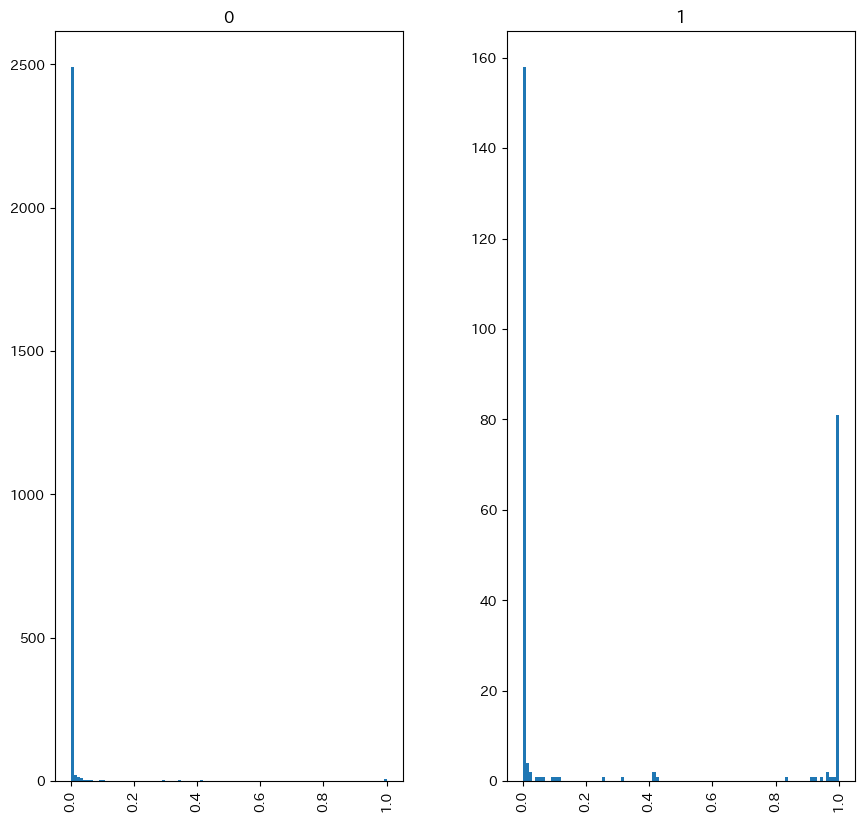

In [ ]:
# y_test, y_pred を結合して、y_test 毎に、y_pred のhistogramを作成
y_test_pred=pd.DataFrame({"y_test":y_val,"y_pred":y_pred})
y_test_pred["y_pred"].hist(by=y_test_pred["y_test"],bins=100,figsize=(10,10))

In [ ]:
# テストデータで予測・評価
y_pred = model.predict(X_test, num_iteration=model.best_iteration,predict_disable_shape_check=True)
y_pred_trans = (y_pred > 0.5).astype(int)

# 評価
accuracy = accuracy_score(y_test, y_pred_trans)
precision = precision_score(y_test, y_pred_trans)
recall = recall_score(y_test, y_pred_trans)
f1 = f1_score(y_test, y_pred_trans)
auc=roc_auc_score(y_test, y_pred)

print('Accuracy:', accuracy, "Precision:", precision, "Recall:", recall, "F1:", f1,"AUC:",auc)

Accuracy: 0.9910757194458368 Precision: 0.057692307692307696 Recall: 0.060066740823136816 F1: 0.05885558583106267 AUC: 0.6403032538331299


array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

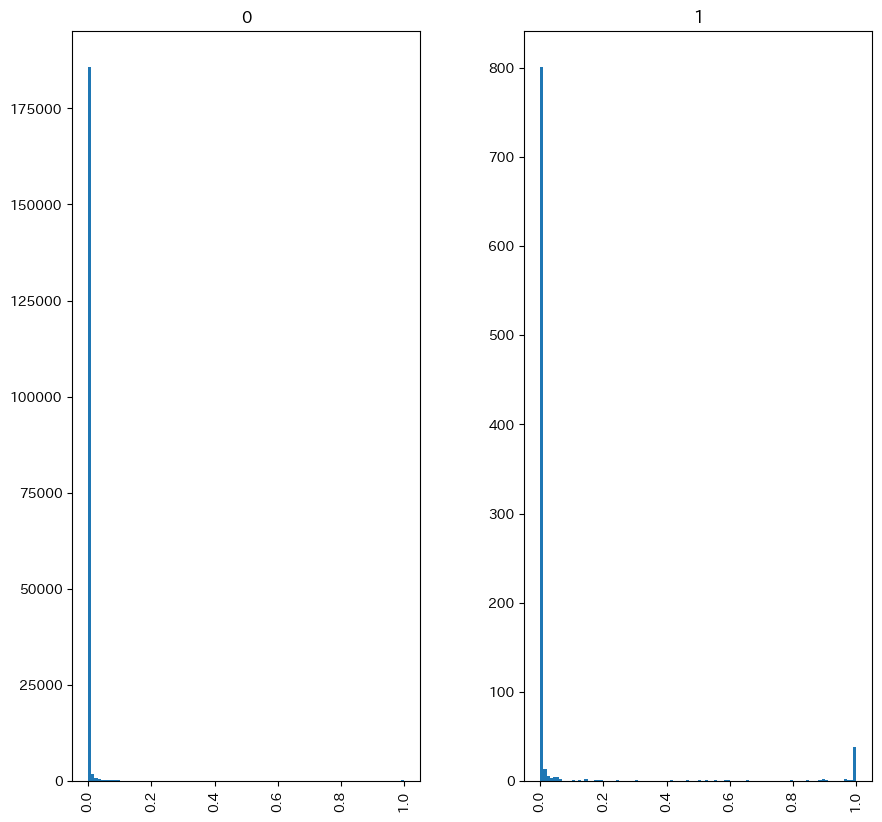

In [ ]:
# y_test, y_pred を結合して、y_test 毎に、y_pred のhistogramを作成
y_test_pred=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
y_test_pred["y_pred"].hist(by=y_test_pred["y_test"],bins=100,figsize=(10,10))

In [ ]:
X_y_test_pred=pd.concat([X_test,y_test_pred],axis=1)

In [ ]:
X_y_test_pred

,northlatitude,eastlongitude,net_reservation_flg,coupons_count,review_count,hozon_count,all_photo_count,openning_days,overview.aggregateRating,overview.reviewCount,...,prefecture_name_長野県,prefecture_name_青森県,prefecture_name_静岡県,prefecture_name_香川県,prefecture_name_高知県,prefecture_name_鳥取県,prefecture_name_鹿児島県,name_size,y_test,y_pred
0,34.872462,136.906819,0,2.0,0,86,71,2290,4.0,38.0,...,0,0,0,0,0,0,0,1,0,6.354887e-08
1,35.711744,139.795447,0,NaN,77,728,156,6149,4.0,197.0,...,0,0,0,0,0,0,0,1,0,1.959518e-05
2,36.229023,137.981748,0,NaN,12,40,26,2262,3.0,40.0,...,1,0,0,0,0,0,0,150,0,1.036497e-03
3,32.577716,131.670341,0,NaN,3,17,5,5360,3.0,19.0,...,0,0,0,0,0,0,0,1,0,1.004009e-06
4,34.615052,134.173741,0,NaN,49,2860,237,4380,4.0,84.0,...,0,0,0,0,0,0,0,2,0,2.157186e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193512,35.798223,139.721366,1,NaN,26,193,95,2139,3.0,388.0,...,0,0,0,0,0,0,0,88,0,4.276061e-08
193513,35.174416,136.886928,1,NaN,109,4714,699,2288,4.0,557.0,...,0,0,0,0,0,0,0,1,0,7.032286e-09
193514,35.700250,139.748353,0,NaN,18,368,63,5334,4.0,52.0,...,0,0,0,0,0,0,0,1,0,4.561457e-02
193515,26.228904,127.718733,0,NaN,0,30,0,5362,4.0,23.0,...,0,0,0,0,0,0,0,13,0,2.835785e-11


In [ ]:
y_test_pred

,y_test,y_pred
0,0,6.354887e-08
1,0,1.959518e-05
2,0,1.036497e-03
3,0,1.004009e-06
4,0,2.157186e-06
...,...,...
193512,0,4.276061e-08
193513,0,7.032286e-09
193514,0,4.561457e-02
193515,0,2.835785e-11


Text(0.5, 1.0, 'LightGBM Feature Importance (gain)')

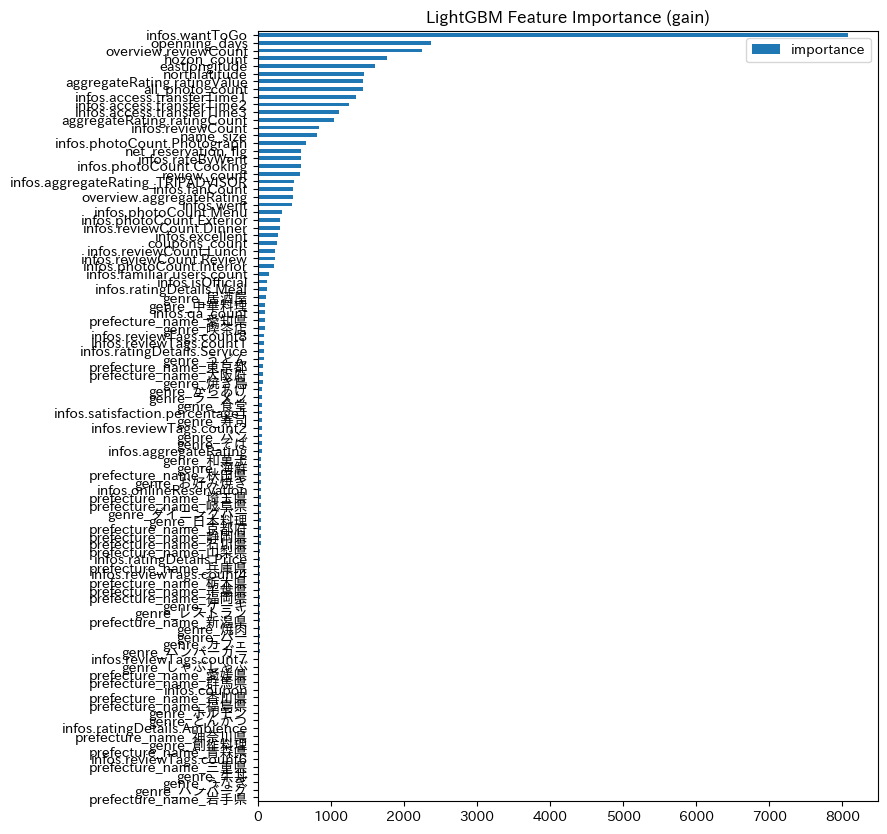

In [ ]:
# feature importance
# 日本語を表示するためにフォントを指定

importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=X.columns, columns=['importance'])
importance.sort_values('importance',ascending=False).head(100).sort_values('importance').plot(kind='barh', figsize=(8, 10))
plt.title('LightGBM Feature Importance (gain)')


In [ ]:
importance.sort_values(by="importance",ascending=False).head(20)

,importance
infos.wantToGo,8078.684632
openning_days,2375.539827
overview.reviewCount,2245.135512
hozon_count,1773.862021
eastlongitude,1604.628976
northlatitude,1460.722032
aggregateRating.ratingValue,1444.088333
all_photo_count,1437.500456
infos.access.transferTime1,1348.873852
infos.access.transferTime2,1242.184475


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


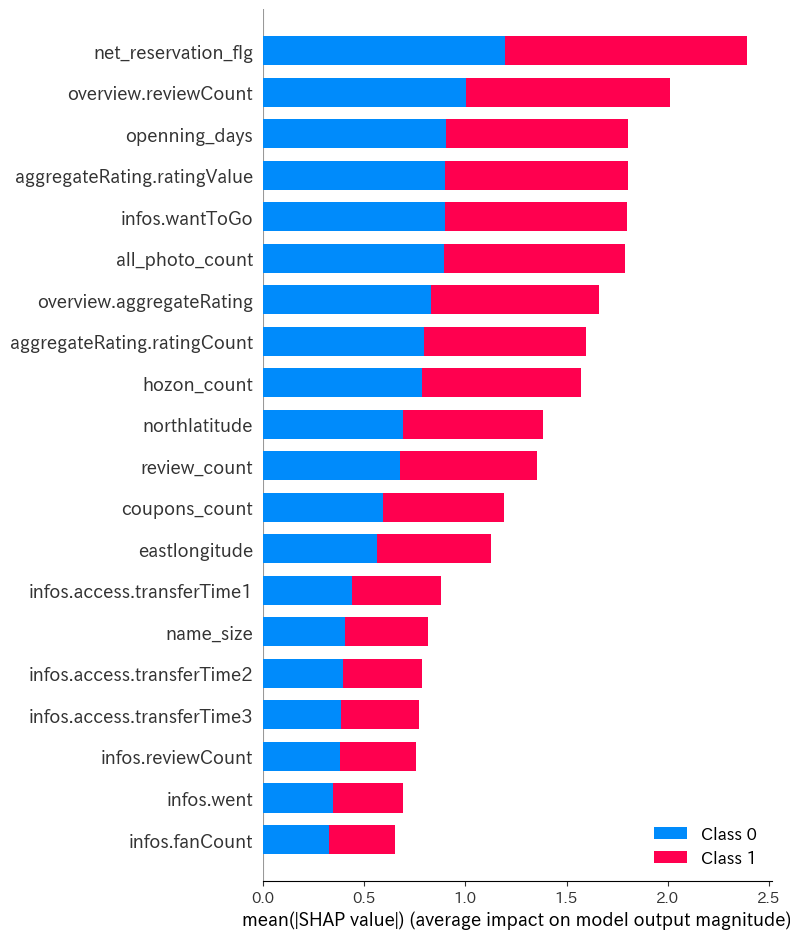

In [ ]:
# shap分析
import shap
shap.initjs()

explainer = shap.TreeExplainer(model=model)

X_test_shap = X_test.head(1000).copy().reset_index(drop=True)
shap_values = explainer.shap_values(X=X_test_shap)
# shap_values をplot
# サンプルごとのshap_valuesをplot
shap.summary_plot(shap_values, X_test_shap,max_display=20)

In [ ]:
%matplotlib inline
import matplotlib
matplotlib.use('TkAgg')  # または別のバックエンドを選択してください

X_test=X_test.head(1)

explainer = shap.Explainer(model, X_test)
shap_values = explainer.shap_values(X_test)

for i in range(len(X_test)):
    shap.initjs()  # Jupyter Notebookでの可視化を初期化する
    shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i,:])  # 各インスタンスのSHAP値をプロットする
    plt.show()  # プロットを表示する

ImportError: libX11.so.6: cannot open shared object file: No such file or directory

In [ ]:
explainer.expected_value

-12.570596654155368

In [ ]:
shap_values[i]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
# 1. モデル shap.Explainer()に渡す
explainer = shap.Explainer(model)

X_test_shap = X_test.head(1000)

# 2. 説明変数(特徴量)を渡す
shap_values = explainer(X_test_shap)

In [ ]:
shap.plots.waterfall(shap_values[0])

TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.